In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import csv

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from keras.models import load_model
from keras.callbacks import EarlyStopping
from h5py._hl.dataset import sel2

C:\Users\jorgo\anaconda3\envs\PPG_based_NIBP\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
#Functions
#데이터 호출 함수 path:경로, 경로 내의 모든 csv파일 호출출

def data_to_Input(data):
        
    data_3d = np.array([])
    data_3d = data[np.newaxis,:,:]
    data_3d = data_3d.transpose((1,2,0))
    
    return data_3d

def BP_dat_plot(dat, title):
    dist_data_sbp = dat[0, :]
    dist_data_dbp = dat[1, :]

    sbp_mean = np.mean(dist_data_sbp)
    dist_data_sbp = dist_data_sbp.astype(int)

    dbp_mean = np.mean(dist_data_dbp)
    dist_data_dbp = dist_data_dbp.astype(int)

    sbp_std = np.std(dat[0, :])
    dbp_std = np.std(dat[1, :])

    fig_bp_dist, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    axs[0].hist(dist_data_sbp, bins=range(min(dist_data_sbp), max(dist_data_sbp)+2))
    axs[0].set_title(title + ' SBP')
    axs[0].axvline(x=sbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=sbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=sbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlabel('SBP value [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(sbp_mean, sbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(dist_data_dbp, bins=range(min(dist_data_dbp), max(dist_data_dbp)+2))
    axs[1].set_title(title + ' DBP')
    axs[1].axvline(x=dbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=dbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=dbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlabel('DBP value [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(dbp_mean, dbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  
  # absolute error
def error_plot(y_test, y_pred):

    y_test_2d = y_test[:,:,0]
    abs_error_sbp = y_test_2d.T[:,0] - y_pred[:,0]
    abs_error_dbp = y_test_2d.T[:,1] - y_pred[:,1]

    aberr_mean_sbp = np.mean(abs_error_sbp)
    aberr_mean_dbp = np.mean(abs_error_dbp)

    aberr_std_sbp = np.std(abs_error_sbp)
    aberr_std_dbp = np.std(abs_error_dbp)

    abs_error_sbp_int = abs_error_sbp.astype(int)
    abs_error_dbp_int = abs_error_dbp.astype(int)

    fig_abs_error, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    axs[0].hist(abs_error_sbp_int, bins=range(min(abs_error_sbp_int), max(abs_error_sbp_int)+2))
    axs[0].set_title('BP-CRNN-50 SBP Error')
    axs[0].axvline(x=aberr_mean_sbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp - aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp + aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlim([-10, 60])
    axs[0].set_xlabel('error [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_sbp, aberr_std_sbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(abs_error_dbp_int, bins=range(min(abs_error_dbp_int), max(abs_error_dbp_int)+2))
    axs[1].set_title('BP-CRNN-50 DBP Error')
    axs[1].axvline(x=aberr_mean_dbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp - aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp + aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlim([-20, 20])
    axs[1].set_xlabel('error [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_dbp, aberr_std_dbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  

def bland_altman_plot(data1, data2, *args, **kwargs):
    """
    Bland-Altman plot to compare two sets of measurements.

    Parameters
    ----------
    data1 : array_like
        The first set of measurements.
    data2 : array_like
        The second set of measurements.
    args : positional arguments
        Additional positional arguments to be passed to plt.scatter().
    kwargs : keyword arguments
        Additional keyword arguments to be passed to plt.scatter().

    Returns
    -------
    fig, ax : tuple
        The matplotlib figure and axes objects.
    """
    data1 = data1.T
    data2 = data2.T

    mean = np.mean([data1, data2], axis=0)
    diff = (data1 - data2)
    md = np.mean(diff, axis=1)
    sd = np.std(diff, axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), tight_layout=False)

    ax[0].scatter(mean[0], diff[0], *args, **kwargs, alpha = 0.5)
    ax[0].axhline(md[0], color='gray', linestyle='--')
    ax[0].axhline(md[0] + 1.96*sd[0], color='red', linestyle='--')
    ax[0].axhline(md[0] - 1.96*sd[0], color='red', linestyle='--')
    ax[0].set_ylim([-30, 30])
    ax[0].set_xlabel('Mean')
    ax[0].set_ylabel('Difference')
    ax[0].set_title('SBP Bland-Altman Plot')

    ax[1].scatter(mean[1], diff[1], *args, **kwargs, alpha = 0.5)
    ax[1].axhline(md[1], color='gray', linestyle='--')
    ax[1].axhline(md[1] + 1.96*sd[1], color='red', linestyle='--')
    ax[1].axhline(md[1] - 1.96*sd[1], color='red', linestyle='--')
    ax[1].set_ylim([-30,30])
    ax[1].set_xlabel('Mean')
    ax[1].set_ylabel('Difference')
    ax[1].set_title('DBP Bland-Altman Plot')

    return fig, ax

def pred_plot(test_dat, pred_dat):
    
    sbp_min = test_dat[:, 0].min()
    sbp_max = test_dat[:, 0].max()
    dbp_min = test_dat[:, 1].min()
    dbp_max = test_dat[:, 1].max()
    
    corr_coef_sbp = np.corrcoef(test_dat[:, 0], pred_dat[:,0])[0, 1]
    corr_coef_dbp = np.corrcoef(test_dat[:, 1], pred_dat[:,1])[0, 1]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), tight_layout=False)
    
    ax[0].plot(test_dat[:, 0], np.poly1d(np.polyfit(test_dat[:, 0], pred_dat[:,0], 1))(test_dat[:, 0]), color='red')
    ax[0].scatter(test_dat[:,0], pred_dat[:,0], c='blue', alpha = 0.5)
    ax[0].text(0.95, 0.95, 'Pearson-R = %.2f'%round(corr_coef_sbp,2), transform=ax[0].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax[0].set_xlim([sbp_min-10, sbp_max+10])
    ax[0].set_ylim([sbp_min-10, sbp_max+10])
    ax[0].set_xlabel('True SBP')
    ax[0].set_ylabel('Estimated SBP')
    ax[0].set_title('SBP')
    
    ax[1].plot(test_dat[:, 1], np.poly1d(np.polyfit(test_dat[:, 1], pred_dat[:,1], 1))(test_dat[:, 1]), color='red')
    ax[1].scatter(test_dat[:,1], pred_dat[:,1], c='blue', alpha = 0.5)
    ax[1].text(0.95, 0.95, 'Pearson-R = %.2f'%round(corr_coef_dbp,2), transform=ax[1].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax[1].set_xlim([dbp_min-10, dbp_max+10])
    ax[1].set_ylim([dbp_min-10, dbp_max+10])
    ax[1].set_xlabel('True DBP')
    ax[1].set_ylabel('Estimated DBP')
    ax[1].set_title('DBP')
    
    print("Pearson-R of SBP: ", corr_coef_sbp)
    print("Pearson-R of DBP: ", corr_coef_dbp)
    
    return fig, ax

In [ ]:
#Load Pretrained Model
Base_model = load_model('F:\\Lab\\Research\\NIBP_PPG\\Materials\\Models\\Ex_1\\2nd_Attempt\\Collective\\Collective_Model_5h_v2.h5')

# Freeze the pre-trained layers
trainable = np.array([4, 5, 12, 13])

for m in range(len(Base_model.layers)):
    if m in trainable:
        Base_model.layers[m].trainable = True
    else:
        Base_model.layers[m].trainable = False
        
TL_model = Base_model

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
TL_model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
callback = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

#TL_model.summary()

#Data load
folder_path = [
    'F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\Vitaldb_dataset\\Preprocessed\\',
    'F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\UQ_dataset\\Preprocessed\\',
    'F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\Vitaldb_dataset\\Preprocessed\\',
    'F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\Vitaldb_dataset\\Preprocessed\\',
    'F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\Vitaldb_dataset\\Preprocessed\\']

folder_num = int(input("Type which dataset you want to use:\n1. Vitaldab = 0\n2. UQ dataset = 1"))
sub_name = input("Type data name: ")

data = np.load(folder_path[folder_num]+sub_name)

x_data = data['x'][np.newaxis,:,:].transpose((1,2,0))
y_data = data['y']

#Sort according to blood pressure
data_count = int(input("데이터 몇 개로 전이학습?: "))
SBP_sort_indx = np.argsort(y_data[:,0])
x_data_sorted = x_data[SBP_sort_indx,:, :]
y_data_sorted = y_data[SBP_sort_indx,:]

train_indx = np.arange(0, x_data.shape[0], x_data.shape[0]//data_count)
test_indx = np.delete(np.arange(0, x_data.shape[0]), train_indx)
test_indx = test_indx[::x_data.shape[0]//720]

x_train = x_data_sorted[train_indx,:]
y_train = y_data_sorted[train_indx,:]
x_test = x_data_sorted[test_indx,:]
y_test = y_data_sorted[test_indx,:]

In [55]:
# fit
callback = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)
hist = TL_model.fit(x_train, y_train, epochs = 200, batch_size=32, validation_data = (x_test ,y_test), verbose = 2, callbacks=[callback])

Epoch 1/200
2/2 - 3s - loss: 136.5458 - mae: 9.0628 - val_loss: 187.6324 - val_mae: 10.1983 - 3s/epoch - 2s/step
Epoch 2/200
2/2 - 0s - loss: 84.3594 - mae: 7.0614 - val_loss: 179.5061 - val_mae: 9.9314 - 353ms/epoch - 176ms/step
Epoch 3/200
2/2 - 0s - loss: 62.2890 - mae: 6.2254 - val_loss: 171.8246 - val_mae: 9.6656 - 352ms/epoch - 176ms/step
Epoch 4/200
2/2 - 0s - loss: 52.0071 - mae: 5.8519 - val_loss: 167.5842 - val_mae: 9.4496 - 346ms/epoch - 173ms/step
Epoch 5/200
2/2 - 0s - loss: 47.7868 - mae: 5.8112 - val_loss: 158.3743 - val_mae: 9.1320 - 345ms/epoch - 172ms/step
Epoch 6/200
2/2 - 0s - loss: 42.0413 - mae: 5.4788 - val_loss: 149.5850 - val_mae: 8.8264 - 343ms/epoch - 171ms/step
Epoch 7/200
2/2 - 0s - loss: 38.4234 - mae: 4.9778 - val_loss: 137.8493 - val_mae: 8.4499 - 345ms/epoch - 172ms/step
Epoch 8/200
2/2 - 0s - loss: 28.9234 - mae: 4.4446 - val_loss: 118.8430 - val_mae: 7.9025 - 335ms/epoch - 168ms/step
Epoch 9/200
2/2 - 0s - loss: 26.8686 - mae: 4.0438 - val_loss: 101.4

Epoch 72/200
2/2 - 0s - loss: 3.2529 - mae: 1.3969 - val_loss: 51.4491 - val_mae: 5.1095 - 235ms/epoch - 117ms/step
Epoch 73/200
2/2 - 0s - loss: 2.7219 - mae: 1.2016 - val_loss: 51.5742 - val_mae: 5.1071 - 236ms/epoch - 118ms/step
Epoch 74/200
2/2 - 0s - loss: 3.8553 - mae: 1.4074 - val_loss: 51.8677 - val_mae: 5.1239 - 254ms/epoch - 127ms/step


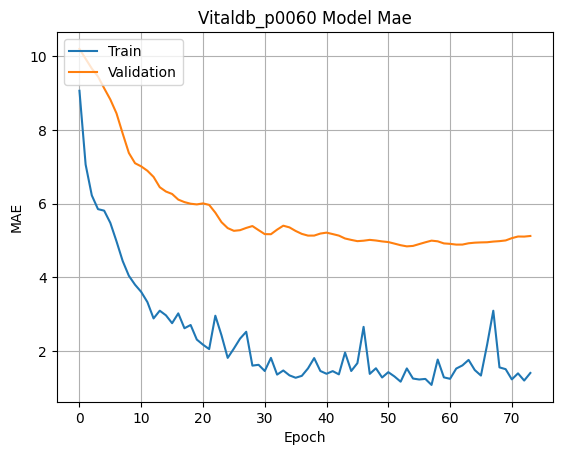

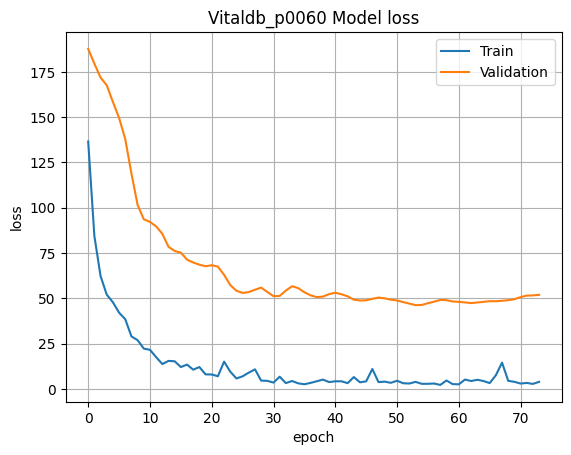

24/24 [==============================] - 1s 7ms/step
MAE for SBP: 6.33
MAE for DBP: 3.35
Pearson-R of SBP:  0.6848928016812743
Pearson-R of DBP:  0.5770880516581669


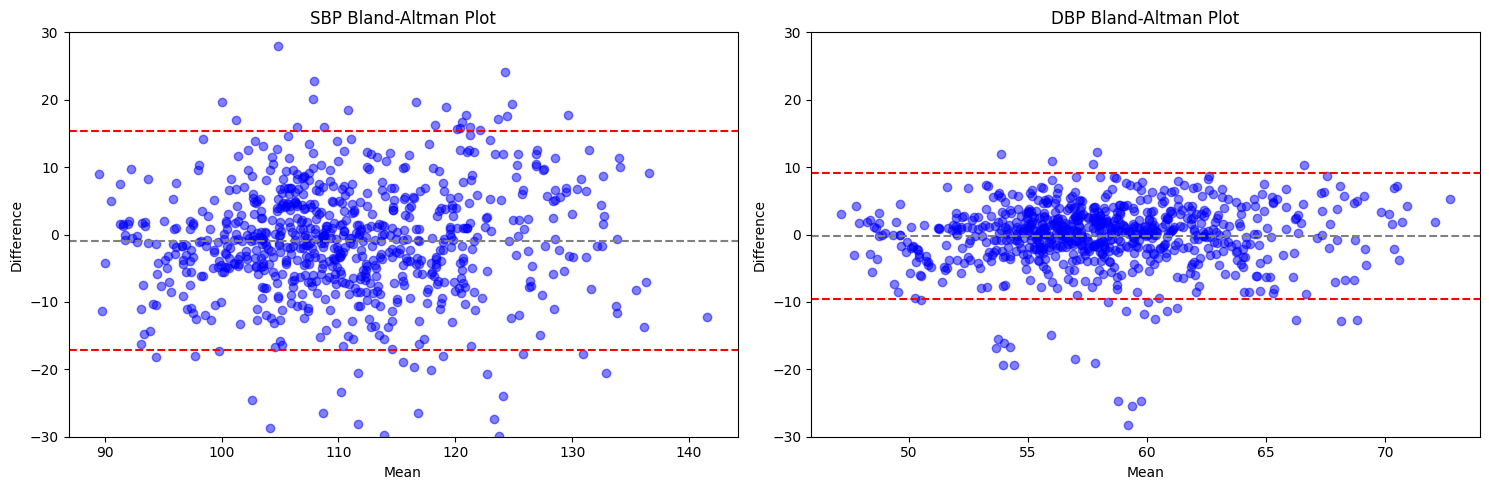

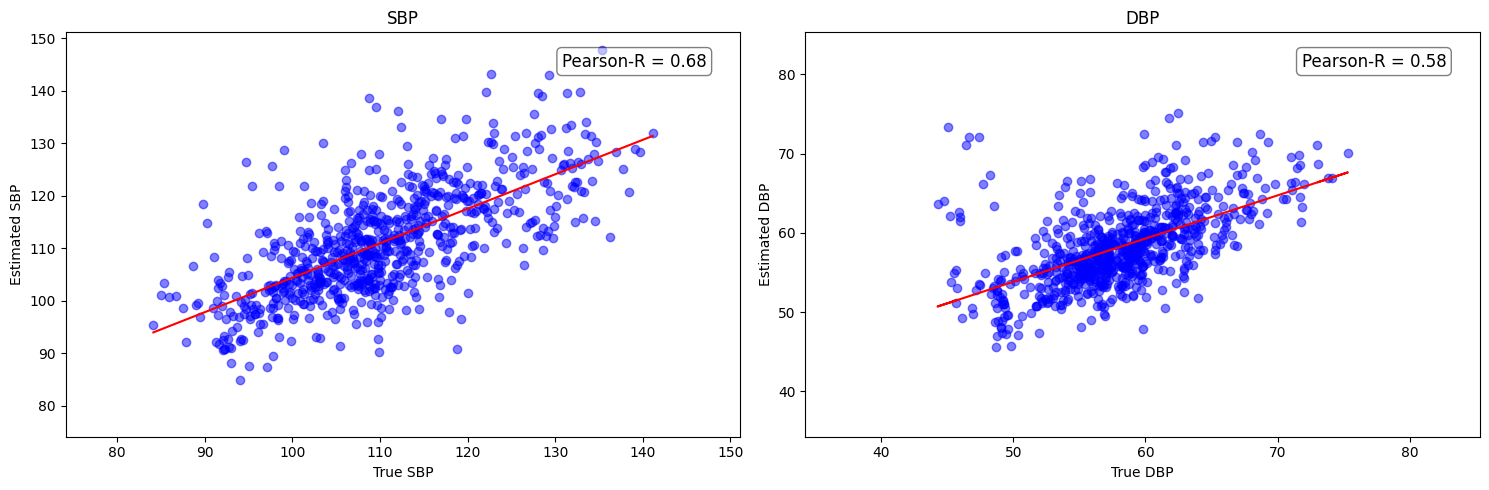

In [56]:
# model 저장 (300번 학습습)
TL_model.save(sub_name[15:22]+'_TL_model.h5')

# 학습 기록
plt.plot(hist.history["mae"])
plt.plot(hist.history["val_mae"])
plt.title(sub_name[10:23]+' Model Mae')
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title(sub_name[10:23]+' Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.grid()
plt.show()

# Predict on test set
y_pred = TL_model.predict(x_test)

print("MAE for SBP: {:.2f}".format(mean_absolute_error(y_test[:,0], y_pred[:,0])))
print("MAE for DBP: {:.2f}".format(mean_absolute_error(y_test[:,1], y_pred[:,1])))

fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, color='blue', marker='o')
fig_ac, ax_ac = pred_plot(y_test, y_pred)

In [12]:
input_shape = (125, 1)

input = tf.keras.Input(shape = input_shape)
# Batch Normalization for each layers

x1 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(input)

x2 = tf.keras.layers.BatchNormalization()(x1)
x2 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(x2)

x3 = tf.keras.layers.BatchNormalization()(x2)
x3 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(x3)

concat = tf.keras.layers.Concatenate(axis = 2)([x1, x3])

x4 = tf.keras.layers.BatchNormalization()(concat)
x4 = tf.keras.layers.GRU(25, return_sequences=True, activation='tanh')(x4)
x4 = tf.keras.layers.Flatten()(x4)

x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = tf.keras.layers.Dense(units=64, activation='relu')(x4)

x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = tf.keras.layers.Dense(units=2, activation='relu')(x4)

output = x4

BP_CRNN_Model = tf.keras.Model(inputs = input, outputs = output)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

BP_CRNN_Model.compile(opt, loss='mean_squared_error', metrics = ['mae'])
BP_CRNN_Model.reset_states() #가중치 초기화
BP_CRNN_Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 125, 50)      400         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 125, 50)     200         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, 125, 50)      17550       ['batch_normalization[0][0]']